# By Ali Moradzade 9831058

In [3]:
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2022-07-02


# توجه 

1. به راهنمایی هایی که در کد آمده است توجه کنید
2. مواردی که به صورت "#TODO"
را باید بصورتی که در صورت پروژه تعریف شده است انجام دهید. 

In [4]:
# ! pip install hazm
# ! pip install gensim==4.1.2
# !pip install words
# !pip install elasticsearch

In [5]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import json
from tqdm import tqdm
from gensim.models import Word2Vec
import random

In [6]:
import numpy as np
import pandas as pd
# import whatever you need for your implementation  

# step 1 
داده هایی که در اختیار دارید را بارگذاری کنید و مشابه بخش های قبل پیش پردازش های لازم را انجام دهید. 
مطابق فازهای و بخش های پیشین پروژه مراحل پیش پردازش را انجام دهید. در نهایت لیست از اسناد بسازید که برای هر متن شامل توکن های آن متن باشد. 
این لیست میتواند ساختاری مطابق تصویر زیر داشته باشد.
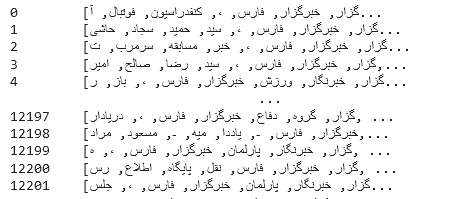

# گام دوم 
در این گام شما باید بتوانید که هر سند را به یک بردار عددی تبدیل کنید. این کار را به کمک ماژول آماده ایی که در اختیار شما قرار گرفته است انجام می شود.
بدین منظور مراحل زیر را انجام دهید. 










## Load Processed Data

In [7]:
train_df = pd.read_excel("data-set/IR01_3_test_4k.xlsx")

In [8]:
train_df.head()

,Unnamed: 0,content,category,url
0,0,به گزارش ایسنا، این شماره از ماهنامه «فکه» به ...,culture,https://www.isna.ir/news/99010100146/فکه-منتشر-شد
1,1,**به گزارش ایسنا** ، رحمت الله فتاحی با پیوستن...,culture,https://www.isna.ir/news/99010100080/شبه-علم-ب...
2,2,به گزارش ایسنا، در پیام نوش آفرین انصاری آمده ...,culture,https://www.isna.ir/news/99010100018/پیام-نورو...
3,3,به گزارش ایسنا، ویژه برنامه تحویل سال شبکه یک ...,culture,https://www.isna.ir/news/99010100013/رسانه-ها-...
4,4,به گزارش ایسنا، کمپین کرونا فایترز (Corona Fig...,culture,https://www.isna.ir/news/98122922416/جشنواره-ه...


In [9]:
train_df = train_df.drop('Unnamed: 0', axis=1)

In [10]:
train_df.head()

,content,category,url
0,به گزارش ایسنا، این شماره از ماهنامه «فکه» به ...,culture,https://www.isna.ir/news/99010100146/فکه-منتشر-شد
1,**به گزارش ایسنا** ، رحمت الله فتاحی با پیوستن...,culture,https://www.isna.ir/news/99010100080/شبه-علم-ب...
2,به گزارش ایسنا، در پیام نوش آفرین انصاری آمده ...,culture,https://www.isna.ir/news/99010100018/پیام-نورو...
3,به گزارش ایسنا، ویژه برنامه تحویل سال شبکه یک ...,culture,https://www.isna.ir/news/99010100013/رسانه-ها-...
4,به گزارش ایسنا، کمپین کرونا فایترز (Corona Fig...,culture,https://www.isna.ir/news/98122922416/جشنواره-ه...


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4022 entries, 0 to 4021
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   4022 non-null   object
 1   category  4022 non-null   object
 2   url       4022 non-null   object
dtypes: object(3)
memory usage: 94.4+ KB


In [12]:
import re
import string
from parsivar import Normalizer
from hazm import word_tokenize
from parsivar import FindStems
from hazm import stopwords_list
from collections import Counter

def del_end_of_message(message):
    return message.replace('انتهای پیام/', '')

def del_punc(content):
    puncs = string.punctuation + "".join(['؛', '_', '،', '؟', '؛', '»', '«', 'ـ', '،'])
    
    return content.translate(content.maketrans("", "", puncs))

normalizer = Normalizer(statistical_space_correction=True)
def normalize(content):
    return normalizer.normalize(content)

def tokenize(content):
    return word_tokenize(content)

stemmer = FindStems()

def stem(content):
    return stemmer.convert_to_stem(content)

persian_stop_words = stopwords_list()

def preprocess(content):
    
    # deleting end of message 
    content = del_end_of_message(content)
    
    # normalizing our content
    content = normalize(content)
    
    # removing punctuation
    content = del_punc(content)
    
    # doing both stemming and tokenization
    words = list(map(lambda term : stem(term), tokenize(content)))
    word_frequency = dict(Counter(words))
    
    # removing stopwords
    for stop_word in stopwords_list():
        if stop_word in word_frequency.keys():
            word_frequency.pop(stop_word)
            
    return word_frequency

Running below cell takes:
    
    CPU times: user 54.1 s, sys: 82.6 ms, total: 54.2 s
    Wall time: 54.2 s

In [13]:
%%time

train_df['preprocessed'] = train_df['content'].apply(preprocess)

CPU times: user 54.8 s, sys: 70.4 ms, total: 54.9 s
Wall time: 54.9 s


In [14]:
train_df.head()

,content,category,url,preprocessed
0,به گزارش ایسنا، این شماره از ماهنامه «فکه» به ...,culture,https://www.isna.ir/news/99010100146/فکه-منتشر-شد,"{'گزارش': 1, 'ایسنا': 1, 'شماره': 1, 'ماهنامه'..."
1,**به گزارش ایسنا** ، رحمت الله فتاحی با پیوستن...,culture,https://www.isna.ir/news/99010100080/شبه-علم-ب...,"{'گزارش': 2, 'ایسنا': 2, 'رحمت‌الله': 1, 'فتاح..."
2,به گزارش ایسنا، در پیام نوش آفرین انصاری آمده ...,culture,https://www.isna.ir/news/99010100018/پیام-نورو...,"{'گزارش': 1, 'ایسنا': 1, 'پیام': 2, 'نوش': 1, ..."
3,به گزارش ایسنا، ویژه برنامه تحویل سال شبکه یک ...,culture,https://www.isna.ir/news/99010100013/رسانه-ها-...,"{'گزارش': 1, 'ایسنا': 1, 'برنامه': 1, 'تحویل':..."
4,به گزارش ایسنا، کمپین کرونا فایترز (Corona Fig...,culture,https://www.isna.ir/news/98122922416/جشنواره-ه...,"{'گزارش': 1, 'ایسنا': 1, 'کمپین‌کرونا‌فایترز':..."


In [15]:
def convert_to_list(dictionary):
    result = []
    for v in dictionary.keys():
        result.append(v)
        
    return result

In [16]:
train_df['preprocessed'] = train_df['preprocessed'].apply(convert_to_list)

In [17]:
train_df['preprocessed'].iloc[0]

['گزارش',
 'ایسنا',
 'شماره',
 'ماهنامه',
 'فکه',
 'پرونده',
 'شهید',
 'مدافع\u200cحرم',
 'سیدمجتبی',
 'سیداسماعیل',
 'حسینی',
 'عنوان',
 'سادات\u200cلشکر',
 'فاطمیون',
 'اختصاص',
 'داشت&دارد',
 'پرواز',
 'ز',
 'جان',
 'بود&باش',
 'قرار',
 'ماهی',
 'گم',
 'شد&شو',
 'عناوین',
 'اصلی',
 'جلد\u200cمانامه\u200cفکه',
 'زندگی',
 'رحمت\u200cالله\u200cعالیشاهی',
 'گفت\u200cوگو',
 'رزمنده',
 'جانباز',
 'احمد',
 'بولیوند',
 'عملیات',
 'بدر',
 'روایت\u200cخادمین',
 'شهد',
 'فدک',
 'پرداخته_است',
 'سال',
 'نوید',
 'رهایی',
 'ماندنی',
 'اس',
 'حاج',
 'قاسم',
 'ترازو',
 'آمریکایی',
 'سخن',
 'نماینده',
 'مجلس',
 'انتهای',
 'پیام']

In [18]:
docs_list = list(train_df['preprocessed'])

دو بلوک بعدی کد برای استفاده از ماژول آماده تهیه شده و صرفا به شکل مثال نوشته شده اند، ممکن است برای استفاده عملی در پروژه نیاز به تغییر باشد. 

In [24]:
from embeding import *
# dataset: each document is a list of its tokens. 
# model_path: is a path that you want save model in it. 
doc2vec = DocToVec(docs_list , vec_size=200 , model_path='word2vec.model')


Loading the model ...



تولید بردارهای تمام اسناد و ذخیره در یک لیست بمنظور استفاده در گام های بعدی 

Running below cell takes:
    
    CPU times: user 19.7 s, sys: 46 ms, total: 19.7 s
    Wall time: 19.7 s

In [25]:
%%time

doc_vectors = []
for i in tqdm(range(len(docs_list))):
  doc_vectors.append(doc2vec.embed(docs_list[i])) 

100%|██████████| 4022/4022 [00:06<00:00, 588.89it/s]

CPU times: user 6.66 s, sys: 28 ms, total: 6.69 s
Wall time: 7.07 s


# ابتدا بردارهای عددی داده های تست را بدست آورده و سپس از این بردارها برای تولید بردار  بقیه ی داده ها استفاده کنید. 

In [26]:
mappings = {
    "properties": {
      "content": {
        "type": "text"
      },
        "category":{
            "type": "keyword"
        },
        "vec":{
            "type": "dense_vector",
            "dims": 200,
            "index": True,
            "similarity": "cosine"
        }
    }
}

In [27]:
es = Elasticsearch("http://localhost:9200")

In [28]:
index_name = 'ir_knn'

In [30]:
# Delete index if one does exist
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

# Create index
es.indices.create(index=index_name, mappings=mappings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ir_knn'})

## Defining `filter_doc` function

In [31]:
def filter_doc(text):
    return preprocess(text)

In [32]:
from copy import deepcopy

data_tmp = []
for i in tqdm(range(len(train_df))):
    tmp_doc = train_df.iloc[i]
    doc = dict()
    # filter_doc: method for preprocessing a doc. 
    doc['content'] = " ".join(filter_doc(tmp_doc['content']))
    doc['vec'] = list(doc_vectors[i])
    doc['category'] = tmp_doc['category']
    data_tmp.append(doc)


100%|██████████| 4022/4022 [00:58<00:00, 69.03it/s] 


In [33]:
data_bulk = [
    {
        "_index" : index_name,
        "_id" : i + 1,
        "_source": data_tmp[i]
    }
    for i in range(len(data_tmp))
]

try:
    resp = helpers.bulk(
      es,
      data_bulk,
      index = index_name
    )
    print(resp)    
except:
    pass

# گام سوم

در این بخش باید داده های تست را بارگذاری و پیش پردازش کنید و سپس برای هر متن بردار آن را بدست آورده و به روش  نزدیکترین همسایه جستجو را انجام داده و برچسب این سند را بدست آورید. 

In [34]:
test_dataset = pd.read_excel("data-set/IR01_3_46k.xlsx")

In [35]:
test_dataset.head()

,Unnamed: 0,content,url
0,0,به گزارش ایسنا، پس از واریز ۴٧۵ هزار یورو از ا...,https://www.isna.ir/news/99121410848/با-بسته-ش...
1,1,به گزارش ایسنا، شانزدهمین دوره مسابقات قهرمانی...,https://www.isna.ir/news/99121410823/برترین-ها...
2,2,به گزارش ایسنا، بر اساس راهنمای گام دوم مبارزه...,https://www.isna.ir/news/99121410760/حضور-غیرق...
3,3,استقلال ملاثانی که با شگفتی سازی در اولین حضور...,https://www.isna.ir/news/99121410724/تعطیلی-تم...
4,4,به گزارش ایسنا، مسابقات اسنوکر قهرمانی آزاد جب...,https://www.isna.ir/news/99121511359/پیروزی-سه...


In [36]:
test_dataset.isna().sum()

Unnamed: 0    0
content       0
url           0
dtype: int64

## Just for time saving:

If you want to predict all the test data comment below line:

In [37]:
test_dataset = test_dataset.iloc[:20]

Running below cell with all test data takes:

    CPU times: user 23min 12s, sys: 4.23 s, total: 23min 16s
    Wall time: 24min 32s

In [38]:
%%time

res = []
for i in tqdm(range(len(test_dataset))):
    vec = doc2vec.embed(filter_doc(test_dataset['content'].iloc[i]))
    try:
        resp = es.knn_search(index=index_name,knn={
          #  TODO
          "field": "vec",
          "query_vector": vec,
          "k": 5,
          "num_candidates": 100
        }
          ,source=['content','category'],)
        res.append(resp)
      #  predict label for doc
      # TODO
    except:
        # usualy happens when all the elements of 
        # the vector are zero.
        res.append(None)

100%|██████████| 20/20 [00:01<00:00, 14.92it/s]

CPU times: user 360 ms, sys: 4.05 ms, total: 364 ms
Wall time: 1.35 s


In [39]:
len(test_dataset)

20

In [40]:
len(res)

20

# گام چهارم 

حال که برای هر متن برچسب آن را بدست آورده اید. متون هر دسته را به نحوی از سایر دسته ها مجزا کنید و مطابق موارد خواسته شده در گزارش جستجو را در دسته های مختلف انجام دهید. 

In [41]:
print(json.dumps(dict(res[0]), indent=4, ensure_ascii=False).encode('utf8').decode())

{
    "took": 926,
    "timed_out": false,
    "_shards": {
        "total": 1,
        "successful": 1,
        "skipped": 0,
        "failed": 0
    },
    "hits": {
        "total": {
            "value": 100,
            "relation": "eq"
        },
        "max_score": 0.75536835,
        "hits": [
            {
                "_index": "ir_knn",
                "_id": "323",
                "_score": 0.75536835,
                "_source": {
                    "category": "culture",
                    "content": "گزارش ایسنا نقل رابطه عمومی معاونت امور فرهنگی وزارت فرهنگ ارشاد اسلامی جلسه 619 هیات انتخاب خرید کتاب 635 عنوان 55 هزار 800 نسخه مبلغ 16 میلیارد 756 میلیون 355 ‌هزارریال تصویب قرار گرفت&گیر توجه لزوم رعایت موزد بهداشتی فاصله‌گذاری اجتماعی وضعیت بحرانی کرونا مقرر صورت‌جلسه یادشده مقطع زمانی فاصله ماه حروف الفبایی ناشر اعلام تحویل انبار‌شود اساس بازه الف ح توانست&توان انبار اقدام کرد&کن عناوین مصوب سایت تارنمای نشانی ‌http‌ ‌mof‌ ‌farhang‌ ‌gov‌ ‌ir‌ fa‌ home‌ ‌book‌ ‌bo

In [42]:
test_dataset.head()

,Unnamed: 0,content,url
0,0,به گزارش ایسنا، پس از واریز ۴٧۵ هزار یورو از ا...,https://www.isna.ir/news/99121410848/با-بسته-ش...
1,1,به گزارش ایسنا، شانزدهمین دوره مسابقات قهرمانی...,https://www.isna.ir/news/99121410823/برترین-ها...
2,2,به گزارش ایسنا، بر اساس راهنمای گام دوم مبارزه...,https://www.isna.ir/news/99121410760/حضور-غیرق...
3,3,استقلال ملاثانی که با شگفتی سازی در اولین حضور...,https://www.isna.ir/news/99121410724/تعطیلی-تم...
4,4,به گزارش ایسنا، مسابقات اسنوکر قهرمانی آزاد جب...,https://www.isna.ir/news/99121511359/پیروزی-سه...


In [43]:
test_dataset = test_dataset.drop('Unnamed: 0', axis=1)

In [44]:
result_list = []

for r in res:
    if r:
        result_list.append(r['hits']['hits'][0]['_source']['category'])
    else:
        result_list.append(None)

In [45]:
test_dataset['category'] = result_list

In [46]:
test_dataset.head()

,content,url,category
0,به گزارش ایسنا، پس از واریز ۴٧۵ هزار یورو از ا...,https://www.isna.ir/news/99121410848/با-بسته-ش...,culture
1,به گزارش ایسنا، شانزدهمین دوره مسابقات قهرمانی...,https://www.isna.ir/news/99121410823/برترین-ها...,culture
2,به گزارش ایسنا، بر اساس راهنمای گام دوم مبارزه...,https://www.isna.ir/news/99121410760/حضور-غیرق...,culture
3,استقلال ملاثانی که با شگفتی سازی در اولین حضور...,https://www.isna.ir/news/99121410724/تعطیلی-تم...,culture
4,به گزارش ایسنا، مسابقات اسنوکر قهرمانی آزاد جب...,https://www.isna.ir/news/99121511359/پیروزی-سه...,culture


In [53]:
for i in range(len(test_dataset)):
    print('category: {}'.format(test_dataset['category'].iloc[i]))
    print('content: \n{}'.format(test_dataset['content'].iloc[i]))

category: culture
content: 
به گزارش ایسنا، پس از واریز ۴٧۵ هزار یورو از اصل طلب ماریو بودیمیر، این باشگاه
باید ٣٢ هزار ۵٠٠ یورو دیگر را بابت سود دیرکرد به حساب این بازیکن واریز می‌کرد.

این مبلغ امروز به حساب بودیمیر رسید تا عملا موضوع پرونده این بازیکن کروات هم
بسته و پنجره نقل‌وانتقالاتی پرسپولیس باز شود.

انتهای پیام


category: culture
content: 
به گزارش ایسنا، شانزدهمین دوره مسابقات قهرمانی کشور از صبح امروز (پنجشنبه 14
اسفند ماه) به میزبانی تالار شهر در جزیره کیش برگزار شد. در این دوره از رقابت
ها 136 فیزیک کار در 6 دسته قدی به مصاف حریفان خود رفتند و در نهایت با معرفی
قهرمانان و برترین های هر دسته به پایان رسید.

پس از رقابت ورزشکاران در رشته فیزیک نوبت به 33 مدعی قهرمانی حاضر در رشته
ماسکولار رسید که لحظاتی قبل برترین های این رشته در دو دسته معرفی شدند.

محمد حسن دابی از اصفهان موفق به کسب سکوی قهرمانی در دسته اول ماسکولار شد و پس
از آن محمد قلی زاده از البرز سایه قهرمانی ایستاد و مرتضی شیخ آبادگر از کیش نفر
سوم این دوره از رقابت ها شد. همچنین عباس موسی نژاد از آذربایجان، یاسی

Did not work :(  
(I do not know what is the bug here)

# Saving our results 

In [64]:
test_dataset.to_pickle('data-set/test_dataset_categorized.pickle')

---